In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as io
import matplotlib.pyplot as plt
from keras import utils as np_utils
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.stats
import sklearn.metrics
import h5py
from keras.callbacks import EarlyStopping
from keras import models, layers, optimizers, backend, constraints, activations, losses
import complexnn
import TIMBRE.helpers as helpers

In [2]:
def csp(X1, y, ridge=0):
    #Trains a CSP filter bank without taking the conjugate in the function to compare accuracy to taking the conjugate inside the function

    unique_classes = np.unique(y)
    S = np.zeros((X1.shape[1], X1.shape[1], len(unique_classes)), dtype='complex')

    for i, u in enumerate(unique_classes):
        class_data = X1[y == u, :]
        S[:, :, i] = np.cov(class_data, rowvar=False) / np.sum(y == u)
        
    Ss = np.sum(S, axis=2)
    Ss += np.diag(np.diag(Ss)) * ridge

    W = np.zeros(S.shape, dtype='complex')
    lambda_vals = np.zeros((S.shape[0], S.shape[2]),dtype='complex')

    for i in range(S.shape[2]):
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Ss).dot(S[:, :, i]))
        sorted_indices = np.argsort(eigvals)[::-1]
        lambda_vals[:, i] = eigvals[sorted_indices]
        W[:, :, i] = eigvecs[:, sorted_indices]

    return W, lambda_vals, S

In [3]:
def csp_conj(X1, y, ridge=0):
    #Trains a CSP filter bank taking the conjugate in the function to compare accuracy to without conjugate

    unique_classes = np.unique(y)
    S = np.zeros((X1.shape[1], X1.shape[1], len(unique_classes)), dtype='complex')

    for i, u in enumerate(unique_classes):
        class_data = X1[y == u, :]
        S[:, :, i] = np.cov(class_data, rowvar=False) / np.sum(y == u)
        
    Ss = np.sum(S, axis=2)
    Ss += np.diag(np.diag(Ss)) * ridge

    W = np.zeros(S.shape, dtype='complex')
    lambda_vals = np.zeros((S.shape[0], S.shape[2]),dtype='complex')

    for i in range(S.shape[2]):
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Ss).dot(np.conj(S[:, :, i])))
        sorted_indices = np.argsort(eigvals)[::-1]
        lambda_vals[:, i] = eigvals[sorted_indices]
        W[:, :, i] = eigvecs[:, sorted_indices]

    return W, lambda_vals

In [4]:
#redefine TIMBRE function with legacy Adam optimizer so it will run on Mac

def TIMBRE(X, Y, inds_test, inds_train, hidden_nodes=0, learn_rate=.001, is_categorical=True, verbosity=0, save_path=None, filename=None):
    """
    Learns oscillatory patterns that are predictive of class labels

    Parameters:
    - X = Multi-channel data (T samples x N channels, complex-valued)
    - Y = Category labels (T samples, integer-valued)
    - inds_test = test indices (Either T x 1 boolean, or U x 1 integers)
    - inds_train = train indices (Either T x 1 boolean, or U x 1 integers)
    - hidden_nodes = how many nodes to use (no hidden layer if set to 0)
    - learn_rate = how quickly the network learns
    - is_categorical = whether the output consists of discrete classes
    - verbosity = amount of model training info to output (default = 0)

    Returns:
    - model: trained network
    - fittedModel: history of loss and accuracy for test and train data
    - test_acc: accuracy on test data after training
    """

    # stack the real and imaginary components of the data
    X = np.concatenate((np.real(X), np.imag(X)), axis=1)
    # use one-hot encoding for the class labels
    if is_categorical:
        Y = np_utils.to_categorical(Y)
        my_loss = 'categorical_crossentropy'
    else:
        my_loss = 'kde'
    backend.clear_session()
    # Early Stopping: stop training model when test loss stops decreasing
    es = EarlyStopping(monitor='val_loss', patience=1)
    # Specify the algorithm and step size used by gradient descent
    adam = optimizers.legacy.Adam(learning_rate=learn_rate)
    if hidden_nodes > 0:
        num_chans = hidden_nodes
    else:
        num_chans = Y.shape[1]
    model = models.Sequential()
    # Layer 1: Takes a complex-valued projection of the input
    model.add(complexnn.dense.ComplexDense(num_chans, input_shape=(X.shape[1],), use_bias=False,
                                           kernel_constraint=constraints.unit_norm()))
    # Layer 2: Converts complex-valued output of layer 0 to a real-valued magnitude
    model.add(layers.Lambda(lambda x: (x[:, :x.shape[1] // 2] ** 2 + x[:, x.shape[1] // 2:] ** 2) ** .5))
    # Layer 3: Softmax of layer 2
    model.add(layers.Activation(activations.softmax))
    if hidden_nodes > 0:  # Need another layer for output
        model.add(layers.Dense(Y.shape[1], activation='softmax'))
    model.compile(loss=my_loss, optimizer=adam, metrics=['accuracy'])
    # Train the model
    fittedModel = model.fit(X[inds_train, :], Y[inds_train, :], epochs=100,
                            verbose=0, validation_data=(X[inds_test, :], Y[inds_test, :]),
                            shuffle=True, callbacks=[es])
    test_acc = fittedModel.history['val_accuracy'][-1]
    
        #Save trained model (addition from original TIMBRE function)
    if filename:
        from keras.models import save_model
        save_model(model, filename + ".h5")
        
    return model, fittedModel, test_acc

In [5]:
def filter(matrix, range_low, range_high, btype='bp', fs = 1250/25, order = 3, use_hilbert = True):
    #Bandpass filter for specific broadbands 
    #TIMBRE filter function will not work for bandpass filters!
    nyq = 0.5*fs
    normal_range_low = range_low / nyq
    normal_range_high = range_high / nyq
    b, a = signal.butter(order, [normal_range_low, normal_range_high], btype=btype, analog=False)
    filt_X = signal.filtfilt(b, a, matrix, axis=0)
    return filt_X 

In [6]:
def band_whiten(X, inds_train, u, Xv):
    X = X @ np.conj(u.T)
    X = X / Xv
    return X

In [7]:
ffs_costs = [0, -1, -2, -3, -4, -5, -6] #different fudge factors/levels of regularization 

accs = np.zeros((3*len(ffs_costs)+2,3,5))
cross_entropy = np.zeros((4*len(ffs_costs)+2,3,5))

In [8]:
for i in range(1,5):
    data = io.loadmat(f'data0{i}.mat') #load drudged data to train models
    lapID = data['lapID']
    theta_preHilbert = filter(data['lfps'], range_low = 6, range_high = 12, btype= 'bp',order= 2) 
    harm_preHilbert = filter(data['lfps'], range_low = 14, range_high = 20, btype= 'bp',order= 2)

    theta_LFPs = signal.hilbert(theta_preHilbert, axis= 0)
    harm_LFPs = signal.hilbert(harm_preHilbert, axis= 0)
    double_LFPs = np.abs(theta_LFPs)*np.exp(np.angle(theta_LFPs)*2*1j)
    
    inds_test, inds_train = helpers.test_train(lapID, 1, n_folds=5, which_fold=0)
    
    for j,c in enumerate(ffs_costs): #run csp withOUT conjugate in function
        theta_csp, theta_lambdas = csp(theta_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**c)
        theta_data = np.abs(np.conj(theta_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1))) #take conjugate here
        CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(theta_data[inds_train],lapID[inds_train,1])
    
        theta_predictions = CSP_model.predict(theta_data[inds_test])
        theta_acc = np.mean(theta_predictions == lapID[inds_test, 1])
        theta_probs = CSP_model.predict_proba(theta_data[inds_test])
        true_labels = lapID[inds_test, 1]
        theta_cross_entropy = sklearn.metrics.log_loss(true_labels, theta_probs)

        harm_data = np.abs(np.conj(harm_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        harm_predictions = CSP_model.predict(harm_data[inds_test])
        harm_acc = np.mean(harm_predictions == lapID[inds_test, 1])
        harm_probs = CSP_model.predict_proba(harm_data[inds_test])
        harm_cross_entropy = sklearn.metrics.log_loss(true_labels, harm_probs)
    
        double_data = np.abs(np.conj(double_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        double_predictions = CSP_model.predict(double_data[inds_test])
        double_acc = np.mean(double_predictions == lapID[inds_test, 1])
        double_probs = CSP_model.predict_proba(double_data[inds_test])
        double_cross_entropy = sklearn.metrics.log_loss(true_labels, double_probs)
    
        accs[j+2,:,i] = [theta_acc, harm_acc, double_acc]
        cross_entropy[j+2,:,i] = [theta_cross_entropy, harm_cross_entropy, double_cross_entropy]
    
    for j,c in enumerate(ffs_costs): #run csp with conjugate in function
        theta_csp, theta_lambdas = csp_conj(theta_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**c)
        theta_data = np.abs(theta_LFPs@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1))) 
        CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(theta_data[inds_train],lapID[inds_train,1])
    
        theta_predictions = CSP_model.predict(theta_data[inds_test])
        theta_acc = np.mean(theta_predictions == lapID[inds_test, 1])
        theta_probs = CSP_model.predict_proba(theta_data[inds_test])
        true_labels = lapID[inds_test, 1]
        theta_cross_entropy = sklearn.metrics.log_loss(true_labels, theta_probs)

        harm_data = np.abs(harm_LFPs@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        harm_predictions = CSP_model.predict(harm_data[inds_test])
        harm_acc = np.mean(harm_predictions == lapID[inds_test, 1])
        harm_probs = CSP_model.predict_proba(harm_data[inds_test])
        harm_cross_entropy = sklearn.metrics.log_loss(true_labels, harm_probs)
    
        double_data = np.abs(double_LFPs@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        double_predictions = CSP_model.predict(double_data[inds_test])
        double_acc = np.mean(double_predictions == lapID[inds_test, 1])
        double_probs = CSP_model.predict_proba(double_data[inds_test])
        double_cross_entropy = sklearn.metrics.log_loss(true_labels, double_probs)
    
        accs[j+len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
        cross_entropy[j+len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
     
     #TIMBRE MODELS   
    full_LFPs = helpers.filter_data(data['lfps'], 2, fs=1250/25, use_hilbert=True)

    w_full, u, Xv = helpers.whiten(full_LFPs, inds_train)
    w_theta = band_whiten(theta_LFPs, inds_train, u, Xv)
    w_harm = band_whiten(harm_LFPs, inds_train, u, Xv)
    w_double = band_whiten(double_LFPs, inds_train, u, Xv)
    
    test_theta = np.concatenate((np.real(w_theta), np.imag(w_theta)), axis=1)
    test_harm = np.concatenate((np.real(w_harm), np.imag(w_harm)), axis=1)
    test_double = np.concatenate((np.real(w_double), np.imag(w_double)), axis=1)

    test_Y = np_utils.to_categorical(lapID[:, 1]) #one-hot encode LapID for testing
    
    n3_model, n3_fittedModel, n3_test_acc = TIMBRE(w_theta, lapID[:, 1], inds_test, inds_train, hidden_nodes=3, save_path="", filename=f"3n_theta_model{i}")
    n0_model, n0_fittedModel, n0_test_acc = TIMBRE(w_theta, lapID[:, 1], inds_test, inds_train, hidden_nodes=0, save_path="", filename=f"0n_theta_model{i}")
    
    TIMBRE_models = [n3_model, n0_model]
    test_data = [test_theta, test_harm, test_double]

    for k in range(len(TIMBRE_models)):
        for j in range(len(test_data)):
            cross_entropy[k,j,i], accs[k,j,i] = TIMBRE_models[k].evaluate(test_data[j][inds_test, :], test_Y[inds_test, :])
    
    
    #Logistic regression of amplitudes
    theta_amps = np.abs(theta_LFPs)
    harm_amps = np.abs(harm_LFPs)
    double_amps = np.abs(double_LFPs) #should be the same as theta
    
    for j,c in enumerate(ffs_costs):
        log_model = sklearn.linear_model.LogisticRegression(penalty='l2', C = 10**c).fit(theta_amps[inds_train],lapID[inds_train,1])

        theta_predictions = log_model.predict(theta_amps[inds_test])
        theta_acc = np.mean(theta_predictions == lapID[inds_test, 1])
        theta_probs = log_model.predict_proba(theta_amps[inds_test])
        true_labels = lapID[inds_test, 1]
        theta_cross_entropy = sklearn.metrics.log_loss(true_labels, theta_probs)

        harm_predictions = log_model.predict(harm_amps[inds_test])
        harm_acc = np.mean(harm_predictions == lapID[inds_test, 1])
        harm_probs = log_model.predict_proba(harm_amps[inds_test])
        harm_cross_entropy = sklearn.metrics.log_loss(true_labels, harm_probs)
    
        double_predictions = log_model.predict(double_amps[inds_test])
        double_acc = np.mean(double_predictions == lapID[inds_test, 1])
        double_probs = log_model.predict_proba(double_amps[inds_test])
        double_cross_entropy = sklearn.metrics.log_loss(true_labels, double_probs)
    
        accs[j+2*len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
        cross_entropy[j+2*len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
        
    print(i)
    print(accs[:,:,i])
    print(cross_entropy[:,:,i])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

101/101 [==============================] - 0s 347us/step - loss: 0.6228 - accuracy: 0.7905


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

1
[[0.9520697  0.72984749 0.76346093]
 [0.93339556 0.77155304 0.79053843]
 [0.63087457 0.24276377 0.55742297]
 [0.6800498  0.50544662 0.38157485]
 [0.77746654 0.56831622 0.351385  ]
 [0.87924059 0.6258948  0.51727358]
 [0.84407096 0.66386555 0.60597572]
 [0.82788671 0.64643635 0.62122627]
 [0.82228447 0.64394647 0.60348584]
 [0.648615   0.35543106 0.60130719]
 [0.73109244 0.38935574 0.69125428]
 [0.83348895 0.43572985 0.74447557]
 [0.85963274 0.46623094 0.72082166]
 [0.84656085 0.48023654 0.76065982]
 [0.82477435 0.54901961 0.69094304]
 [0.81917211 0.54684096 0.60504202]
 [0.81481481 0.46747588 0.81481481]
 [0.81139122 0.46000622 0.81139122]
 [0.81170246 0.45533769 0.81170246]
 [0.80827887 0.4659197  0.80827887]
 [0.81139122 0.46623094 0.81139122]
 [0.81761594 0.46436352 0.81761594]
 [0.79925303 0.4379085  0.79925303]]
[[0.16001567 0.72460419 0.81129682]
 [0.53394628 0.93840891 0.62278968]
 [0.92190019 1.46317556 1.40397247]
 [0.72517555 1.10339557 2.07160861]
 [0.52810005 0.94046555 3

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

51/51 [==============================] - 0s 300us/step - loss: 0.4580 - accuracy: 0.9595


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

2
[[0.98129678 0.59102243 0.9625935 ]
 [0.98004985 0.58665836 0.95947629]
 [0.54987531 0.26433915 0.58915212]
 [0.67955112 0.42518703 0.47630923]
 [0.81795511 0.45573566 0.63466334]
 [0.81359102 0.52057357 0.55610973]
 [0.86346633 0.54862843 0.75311721]
 [0.86034913 0.58291771 0.7213217 ]
 [0.85972569 0.58915212 0.69887781]
 [0.64276808 0.39900249 0.66957606]
 [0.74002494 0.45822943 0.66583541]
 [0.79488778 0.45885287 0.6701995 ]
 [0.85099751 0.46508728 0.73254364]
 [0.89276808 0.47256858 0.78553616]
 [0.90773067 0.48815461 0.77930175]
 [0.91147132 0.49688279 0.74189526]
 [0.67206983 0.44700748 0.67206983]
 [0.6701995  0.43142145 0.6701995 ]
 [0.70573566 0.44326683 0.70573566]
 [0.66458853 0.42394015 0.66458853]
 [0.70199501 0.44887781 0.70199501]
 [0.67144638 0.44077307 0.67144638]
 [0.67643392 0.42206983 0.67643392]]
[[0.14733724 0.88970572 0.12230577]
 [0.60857099 1.02235174 0.45803064]
 [0.89323932 1.53633104 0.90208255]
 [0.72560772 1.24842838 1.61532801]
 [0.50473987 1.85381116 1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

53/53 [==============================] - 0s 745us/step - loss: 1.1499 - accuracy: 0.4310


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

3
[[0.93043995 0.636742   0.57847798]
 [0.96254456 0.60404283 0.43103448]
 [0.58680143 0.28834721 0.54458977]
 [0.76872771 0.40665874 0.53686088]
 [0.78299643 0.41319857 0.3608799 ]
 [0.88347206 0.54221165 0.3549346 ]
 [0.92865636 0.58026159 0.43162901]
 [0.92687277 0.57312723 0.5059453 ]
 [0.92390012 0.6058264  0.53091558]
 [0.58858502 0.34363853 0.41617122]
 [0.71403092 0.40130797 0.43757432]
 [0.8412604  0.54875149 0.343044  ]
 [0.85315101 0.56896552 0.26516052]
 [0.85731272 0.539239   0.27288942]
 [0.84839477 0.53686088 0.27942925]
 [0.85255648 0.5469679  0.27764566]
 [0.83115339 0.44827586 0.83115339]
 [0.83055886 0.46789536 0.83055886]
 [0.8353151  0.460761   0.8353151 ]
 [0.80915577 0.4667063  0.80915577]
 [0.83234245 0.4548157  0.83234245]
 [0.84244946 0.48573127 0.84244946]
 [0.83412604 0.45422117 0.83412604]]
[[0.2177241  0.86932242 1.3238281 ]
 [0.50205523 1.0056175  1.14989042]
 [0.94735879 1.6429925  1.23191562]
 [0.63200919 1.23225488 2.13570329]
 [0.53465846 1.33885762 6

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

50/50 [==============================] - 0s 321us/step - loss: 0.5227 - accuracy: 0.8503


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

4
[[0.9923858  0.64149743 0.71954316]
 [0.9923858  0.64086294 0.85025382]
 [0.55393401 0.22906091 0.39086294]
 [0.64593909 0.36230964 0.55266497]
 [0.86294416 0.49238579 0.40164975]
 [0.98857868 0.5285533  0.67829949]
 [0.9892132  0.6180203  0.54060914]
 [0.95875635 0.6034264  0.46573604]
 [0.91878173 0.58819797 0.5       ]
 [0.56091371 0.32677665 0.38071066]
 [0.65101523 0.43147208 0.4498731 ]
 [0.78172589 0.45177665 0.32804569]
 [0.84961929 0.50761421 0.34898477]
 [0.84961929 0.49428934 0.43083756]
 [0.83185279 0.46319797 0.49555838]
 [0.8248731  0.45494924 0.54314721]
 [0.74238579 0.4714467  0.74238579]
 [0.76903553 0.45558376 0.76903553]
 [0.73032995 0.46446701 0.73032995]
 [0.73159898 0.44606599 0.73159898]
 [0.74682741 0.45621827 0.74682741]
 [0.72969543 0.46510152 0.72969543]
 [0.75634518 0.44352792 0.75634518]]
[[0.04531755 0.81305891 1.15658164]
 [0.46563163 0.99720204 0.52269363]
 [0.92989716 1.51605482 1.19420031]
 [0.79128267 1.25264721 1.23720206]
 [0.36812494 1.20422359 3

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
#Average across sessions
avg_accs = np.mean(accs[:,:,1:], axis = 2)
avg_cross = np.mean(accs[:,:,1:], axis = 2)

print(avg_accs)
print(avg_cross)

[[0.96404806 0.64977734 0.75601889]
 [0.96709394 0.65077929 0.75782575]
 [0.58037133 0.25612776 0.52050695]
 [0.69356693 0.42490051 0.48685248]
 [0.81034056 0.48240906 0.4371445 ]
 [0.89122059 0.55430833 0.52665435]
 [0.90635171 0.60269397 0.58283277]
 [0.89346624 0.60147692 0.57855733]
 [0.881173   0.60678074 0.58331981]
 [0.61022045 0.35621218 0.51694128]
 [0.70904088 0.4200913  0.56113428]
 [0.81284076 0.47377771 0.52144119]
 [0.85335014 0.50197449 0.51687765]
 [0.86156523 0.49658336 0.56248074]
 [0.85318815 0.50930827 0.5613081 ]
 [0.85201825 0.51141022 0.54193254]
 [0.76510595 0.45855148 0.76510595]
 [0.77029628 0.4537267  0.77029628]
 [0.77077079 0.45595813 0.77077079]
 [0.75340554 0.45065804 0.75340554]
 [0.77313902 0.45653568 0.77313902]
 [0.7653018  0.46399235 0.7653018 ]
 [0.76653954 0.43943185 0.76653954]]
[[0.96404806 0.64977734 0.75601889]
 [0.96709394 0.65077929 0.75782575]
 [0.58037133 0.25612776 0.52050695]
 [0.69356693 0.42490051 0.48685248]
 [0.81034056 0.48240906 0.4

In [10]:
theta_accs = avg_accs[:,0]
harm_accs = avg_accs[:,1]
double_accs = avg_accs[:,2]

print(len(theta_accs))


23


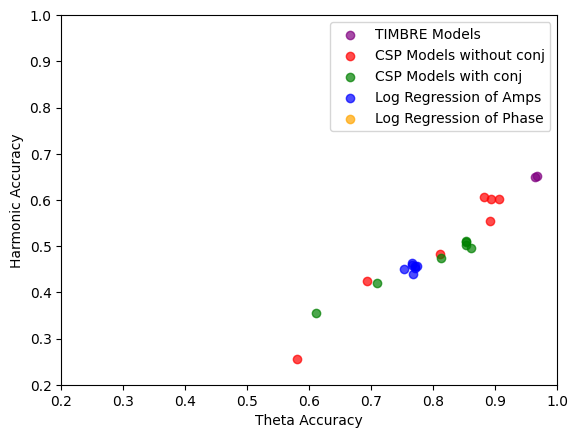

In [11]:
plt.scatter(theta_accs[:2], harm_accs[:2], c='Purple', label='TIMBRE Models', alpha = 0.7)
plt.scatter(theta_accs[2:9], harm_accs[2:9], c='Red', label='CSP Models without conj', alpha = 0.7)
plt.scatter(theta_accs[9:16], harm_accs[9:16], c='Green', label='CSP Models with conj', alpha = 0.7)
plt.scatter(theta_accs[16:23], harm_accs[16:23], c='Blue', label='Log Regression of Amps', alpha = 0.7)
plt.scatter(theta_accs[23:], harm_accs[23:], c='Orange', label='Log Regression of Phase', alpha = 0.7)


plt.xlabel('Theta Accuracy')
plt.ylabel('Harmonic Accuracy')

plt.xlim(0.2, 1)
plt.ylim(0.2, 1)

plt.legend()
plt.show()

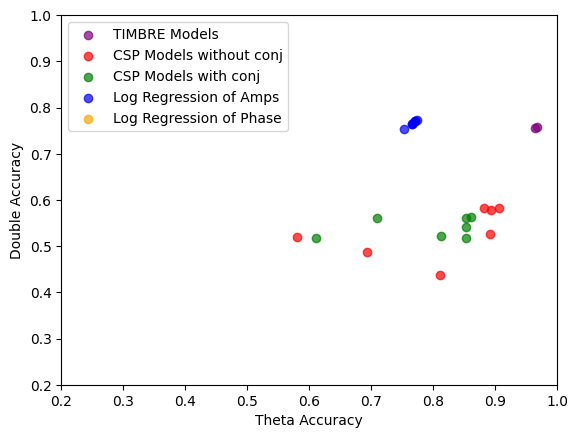

In [12]:
plt.scatter(theta_accs[:2], double_accs[:2], c='Purple', label='TIMBRE Models', alpha = 0.7)
plt.scatter(theta_accs[2:9], double_accs[2:9], c='Red', label='CSP Models without conj', alpha = 0.7)
plt.scatter(theta_accs[9:16], double_accs[9:16], c='Green', label='CSP Models with conj', alpha = 0.7)
plt.scatter(theta_accs[16:23], double_accs[16:23], c='Blue', label='Log Regression of Amps', alpha = 0.7)


plt.xlabel('Theta Accuracy')
plt.ylabel('Double Accuracy')

plt.xlim(0.2, 1)
plt.ylim(0.2, 1)

plt.legend()
plt.show()

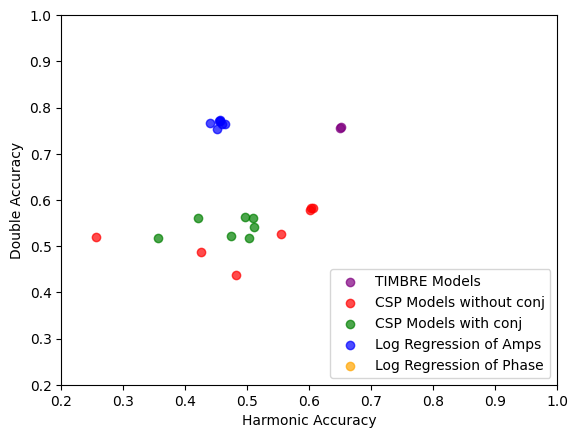

In [13]:
plt.scatter(harm_accs[:2], double_accs[:2], c='Purple', label='TIMBRE Models', alpha = 0.7)
plt.scatter(harm_accs[2:9], double_accs[2:9], c='Red', label='CSP Models without conj', alpha = 0.7)
plt.scatter(harm_accs[9:16], double_accs[9:16], c='Green', label='CSP Models with conj', alpha = 0.7)
plt.scatter(harm_accs[16:24], double_accs[16:24], c='Blue', label='Log Regression of Amps', alpha = 0.7)
plt.scatter(harm_accs[24:], double_accs[24:], c='Orange', label='Log Regression of Phase', alpha = 0.7)


plt.xlabel('Harmonic Accuracy')
plt.ylabel('Double Accuracy')

plt.xlim(0.2, 1)
plt.ylim(0.2, 1)

plt.legend()
plt.show()